In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)



In [6]:
# View all of the classes that automap found

Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station

Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
#session.query(Measurement.date).first()
query=session.query(Measurement).order_by(Measurement.date.desc()).first()
print(query.date)
print(f"The last existing date in the Measurement data was: {query.date}")


2017-08-23
The last existing date in the Measurement data was: 2017-08-23


In [10]:
# 2). Finding the last 12 months FROM last date in data (last 12 mo - 365d) 
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"12 months from last existing date: {last_12_months}")

# 3). Perform a query to retrieve the data and precipitation scores for 'last12mo'
last_year_precipitation = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= last_12_months).order_by(Measurement.date).all()
    # last_year_precipitation

# 4). Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(last_year_precipitation, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)


#prcp_final=prcp_1617_df.sort_values(by=['Date'])
df = df.sort_index()
df

12 months from last existing date: 2016-08-23


,date,precipitation
date,,
2016-08-23,2016-08-23,0.0
2016-08-23,2016-08-23,3.8
2016-08-23,2016-08-23,1.3
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,0.5
...,...,...
2017-08-22,2017-08-22,12.7
2017-08-23,2017-08-23,0.0
2017-08-23,2017-08-23,0.0


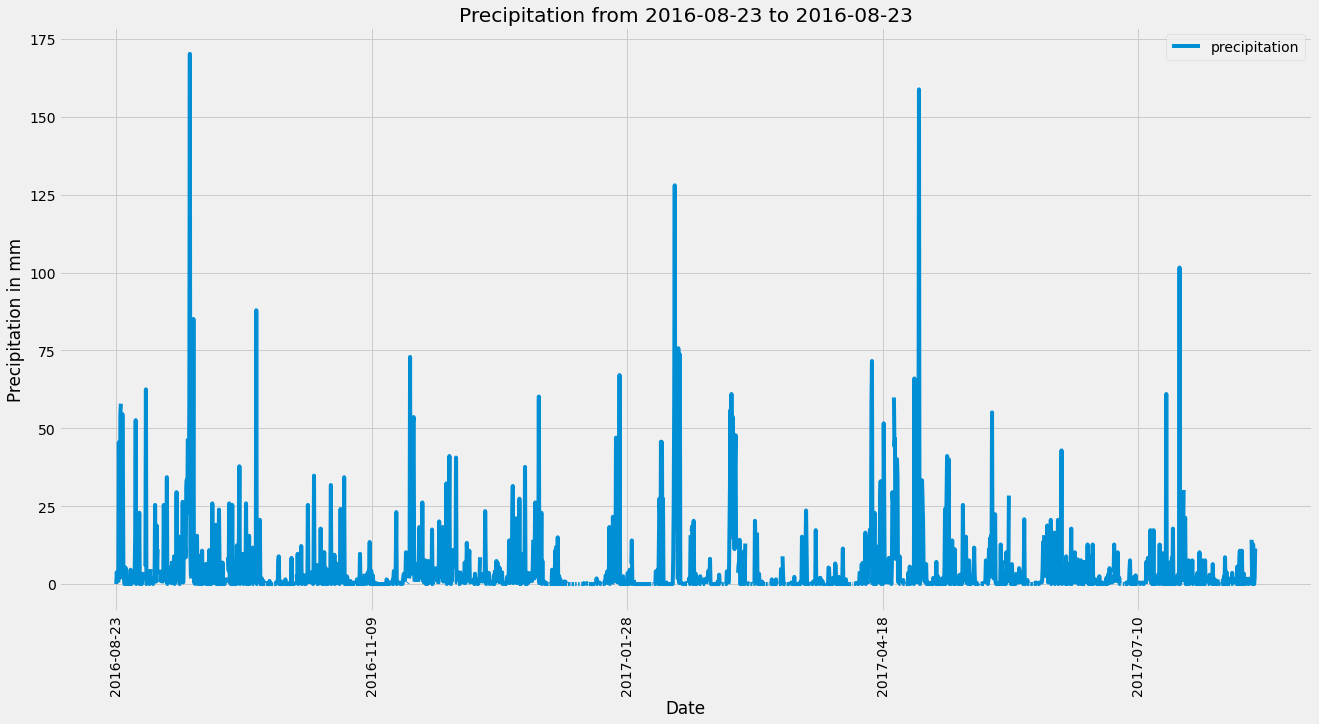

In [39]:
# 6). Plot the results using the DataFrame `plot` method.


fig=df.plot(rot=90, figsize=(20,10))
fig.set(xlabel='Date', ylabel='Precipitation in mm',title='Precipitation from 2016-08-23 to 2016-08-23')

plt.title = ()
plt.legend = ("Precipitation")

plt.savefig('Images/Precipitation_Plot.png')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

new_df=pd.read_csv("Resources/hawaii_measurements.csv")
new_df.describe()

,prcp,tobs
count,18103.000000,19550.000000
mean,4.083920,22.832118
std,11.905419,2.513311
min,0.000000,11.700000
25%,0.000000,21.100000
50%,0.300000,22.800000
75%,2.800000,24.400000
max,292.900000,30.600000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stations_total = session.query(Station).count()
print(f"The total number of stations in this data set is: {stations_total}")

The total number of stations in this data set is: 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations_locations = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

print(f"Most active stations:")
active_stations_df = pd.DataFrame(active_stations_locations, columns=['Station Name', "Observation Count"])
active_stations_df

Most active stations:


,Station Name,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    limit(1).scalar()

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).\
    all()

[(12.2, 29.4, 22.03582251082252)]

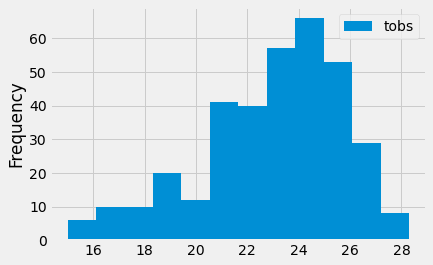

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_tobs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date>= last_12_months).statement

tobs_df = pd.read_sql(measurement_tobs, conn)
tobs_df.plot(kind='hist', bins=12)
plt.savefig('Images/Histogram.png')
plt.show()



# Close session

In [17]:
# Close Session
session.close()